In [1]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import ArrayType, FloatType, IntegerType, StringType, StructType, StructField
from pyspark.sql.functions import concat, lit
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

In [2]:
spark = SparkSession.builder.appName("Traffic Signs Classification") \
  .master("local[*]") \
  .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
  .config("spark.rapids.sql.enabled", "true") \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g") \
  .config("spark.python.worker.memory", "12g") \
  .config("spark.executor.pyspark.memory", "12g") \
  .config("spark.rpc.message.maxSize", "128") \
  .config("spark.executor.memoryOverhead", "2g") \
  .config("spark.executor.heartbeatInterval", "30s") \
  .config("spark.network.timeout", "300s") \
  .config("spark.sql.adaptive.enabled", "true") \
  .config("spark.memory.fraction", "0.6") \
  .config("spark.driver.maxResultSize", "2g") \
  .config("spark.sql.shuffle.partitions", "20") \
  .config("spark.default.parallelism", "20") \
  .getOrCreate()
  
spark.sparkContext.setLogLevel("ERROR")
  
  # .config('spark.driver.extraClassPath', 'rapids-4-spark_2.13-24.10.1.jar') \
  # .config('spark.executor.extraClassPath', 'rapids-4-spark_2.13-24.10.1.jar') \
  # .config("spark.plugins", "com.nvidia.spark.rapids.GpuPlugin") \
  # .config("spark.sql.extensions", "com.nvidia.spark.rapids.SQLExecPlugin") \
  # .config("spark.executor.resource.gpu.amount", "1") \
  
  
  #   .master("local[*]") \
  # .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  # .config("spark.local.dir", "/mnt/e/spark-temp") \
  # .config("spark.eventLog.dir", "/mnt/e/spark-event-logs") \
  
  
  # .master("local[*]") \
  # 
  # .config("spark.executor.extraJavaOptions", "-XX:+PrintGCDetails -XX:+PrintGCDateStamps -Xloggc:tmp/gc.log") \
  # .config("spark.sql.execution.arrow.pyspark.enabled", "false") \


your 131072x1 screen size is bogus. expect trouble
24/12/19 21:50:33 WARN Utils: Your hostname, DESKTOP-SMHNFU4 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/19 21:50:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 21:50:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataset_path = './dataset'

if not os.path.exists(dataset_path):
  raise BaseException("Path not found")

schema = StructType([
    StructField("Width", IntegerType(), True),
    StructField("Height", IntegerType(), True),
    StructField("Roi.X1", IntegerType(), True),
    StructField("Roi.Y1", IntegerType(), True),
    StructField("Roi.X2", IntegerType(), True),
    StructField("Roi.Y2", IntegerType(), True),
    StructField("ClassId", IntegerType(), True),
    StructField("Path", StringType(), True)
])

train_metadata_df = spark.read.csv(os.path.join(dataset_path, 'Train.csv'), schema=schema, header=True)
train_metadata_df = train_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), train_metadata_df["Path"])).dropna(subset=["ClassId"])
train_metadata_df.show()

+-----+------+------+------+------+------+-------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|
+-----+------+------+------+------+------+-------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|
|   31|    29|     5|     6|    26|    24|     20|./dataset/Train/2...|
|   34|    32|     6|     6|    29|    26|     20|./dataset/Train/2...|
|   36|    33|     5|     6|    31|    28|     20|./dataset/Trai

In [4]:
class_labels = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of Speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No overtaking",
    10: "No overtaking for trucks",
    11: "Priority at next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no overtaking",
    42: "End of no overtaking for trucks"
}


In [5]:
def process_image(img_path, roi_x1, roi_y1, roi_x2, roi_y2):
    try:
        img = Image.open(img_path)
        cropped_img = img.crop((roi_x1, roi_y1, roi_x2, roi_y2))
        resized_img = np.array(cropped_img.resize((32, 32), resample=Image.Resampling.LANCZOS))
        return (resized_img.flatten() / 255.0).tolist()
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return [0.0] * (32 * 32 * 3)

def image_to_vector(img_features):
    return Vectors.dense(img_features)

image_to_vector_udf = udf(image_to_vector, VectorUDT())

processed_df = train_metadata_df.withColumn(
    "features",
    udf(lambda path, x1, y1, x2, y2: process_image(path, x1, y1, x2, y2), ArrayType(FloatType()))(
        train_metadata_df["Path"], train_metadata_df["`Roi.X1`"], train_metadata_df["`Roi.Y1`"],
        train_metadata_df["`Roi.X2`"], train_metadata_df["`Roi.Y2`"]
    )
)

processed_df = processed_df.withColumn("features", image_to_vector_udf("features"))

processed_df.show()

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



+-----+------+------+------+------+------+-------+--------------------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|
+-----+------+------+------+------+------+-------+--------------------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|[0.2,0.1960784313...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|[0.19607843137254...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

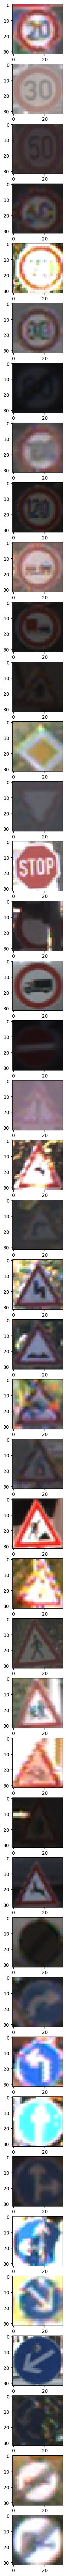

In [6]:
fig, ax = plt.subplots(len(class_labels), figsize=(10, 100))

for key in class_labels:
  img = processed_df.filter(processed_df.ClassId == key).limit(1).toPandas()

  reshaped_image = img.iloc[0].features.reshape(32, 32, 3)
  ax[key].imshow(reshaped_image)
  
plt.show()

In [7]:
train_df, test_df = processed_df.randomSplit([0.8, 0.2])
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train count: {train_df.count()}")
print(f"Test count: {test_df.count()}")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              



Train count: 31422


Test count: 7787


In [8]:
train_df.write.format("parquet").mode("overwrite").save("train_df.parquet")
test_df.write.format("parquet").mode("overwrite").save("test_df.parquet")

In [9]:
train_df = spark.read.parquet("train_df.parquet")
test_df = spark.read.parquet("test_df.parquet")

print(f"Train count: {train_df.count()}")
print(f"Test count: {test_df.count()}")

Train count: 31422
Test count: 7787


In [10]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="ClassId", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="ClassId", predictionCol="prediction", metricName="f1")

Logistic regression

In [11]:
lr = LogisticRegression(featuresCol="features", labelCol="ClassId", maxIter=80)
pipeline = Pipeline(stages=[lr])

paramGrid_lr = ParamGridBuilder() \
  .addGrid(lr.regParam, [1e-3]) \
  .addGrid(lr.tol, [0]) \
  .addGrid(lr.elasticNetParam, [0.01]) \
  .build()


cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_accuracy, numFolds=5, seed=1234)

model = cv.fit(train_df)

bestModel = model.bestModel
bestModel.write().overwrite().save("best-model-lr")

In [12]:
bestModel = PipelineModel.load("best-model-lr")

predictions = bestModel.transform(test_df)
accuracy = evaluator_accuracy.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print(f"Best accuracy: {accuracy}")
print(f"Best f1: {f1}")


print(f"Best param: regParam={bestModel.stages[-1].getRegParam()} elasticNetParam={bestModel.stages[-1].getElasticNetParam()} tol={bestModel.stages[-1].getTol()} maxInter={bestModel.stages[-1].getMaxIter()}")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



Best accuracy: 0.913060228586105
Best f1: 0.9126203842593498
Best param: regParam=0.001 elasticNetParam=0.01 tol=0.0 maxInter=80


In [ ]:
def show_confusion_matrix(predictions):
    predictions_pd = predictions.toPandas()

    conf_matrix = confusion_matrix(predictions_pd['ClassId'], predictions_pd['prediction'])

    fig, ax = plt.subplots(figsize=(30, 8))
    cax = ax.matshow(conf_matrix, cmap="Blues")

    plt.colorbar(cax)

    ax.set_xticks(range(len(class_labels)))
    ax.set_yticks(range(len(class_labels)))
    ax.set_xticklabels(class_labels, fontsize=7)
    ax.set_yticklabels(class_labels, fontsize=7)

    plt.title("Confusion Matrix", pad=20)
    plt.xlabel("Predicted", labelpad=10)
    plt.ylabel("Actual", labelpad=10)

    for (i, j), value in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

    plt.tight_layout()
    plt.show()

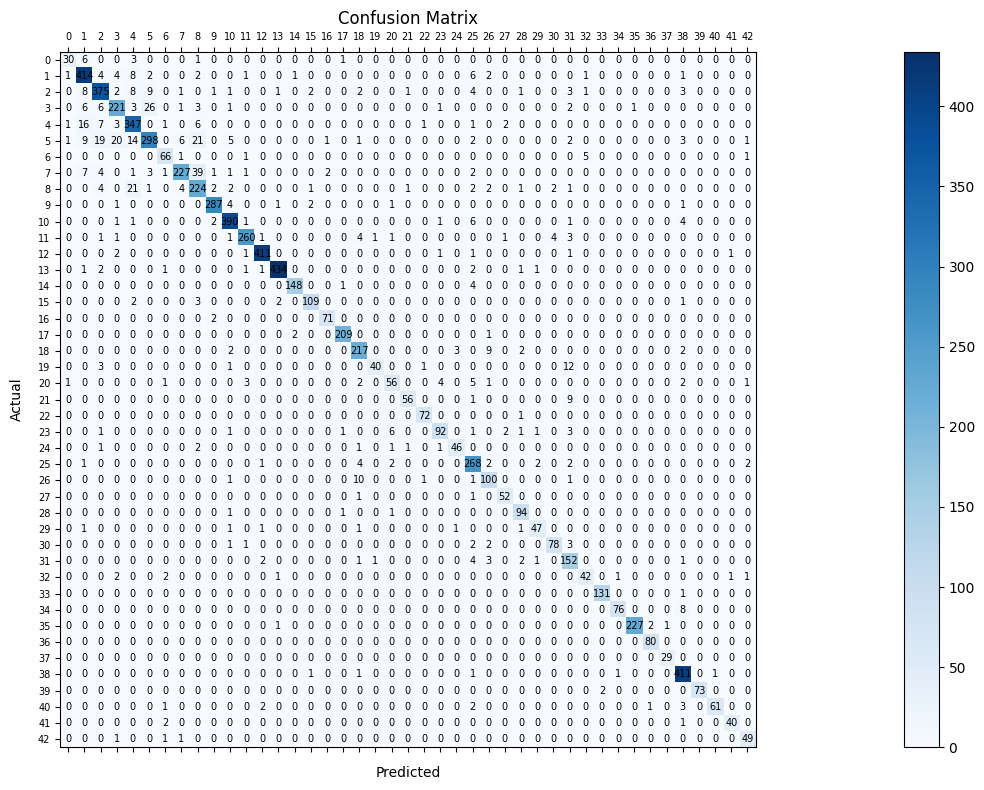

In [14]:
show_confusion_matrix(predictions)

In [15]:
test_metadata_df = spark.read.csv(os.path.join(dataset_path, 'Test.csv'), schema=schema, header=True)
test_metadata_df = test_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), test_metadata_df["Path"]))

processed_test_df = test_metadata_df.withColumn(
    "features",
    udf(lambda path, x1, y1, x2, y2: process_image(path, x1, y1, x2, y2), ArrayType(FloatType()))(
        test_metadata_df["Path"], test_metadata_df["`Roi.X1`"], test_metadata_df["`Roi.Y1`"],
        test_metadata_df["`Roi.X2`"], test_metadata_df["`Roi.Y2`"]
    )
)

processed_df = processed_df.withColumn("features", image_to_vector_udf("features"))

processed_df.show()

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



+-----+------+------+------+------+------+-------+--------------------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|
+-----+------+------+------+------+------+-------+--------------------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|[0.2,0.1960784313...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|[0.19607843137254...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...

In [16]:
final_predictions = bestModel.transform(processed_df)

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              



Final results:
Accuracy: 0.9204774414037593
F1: 0.920190339912166


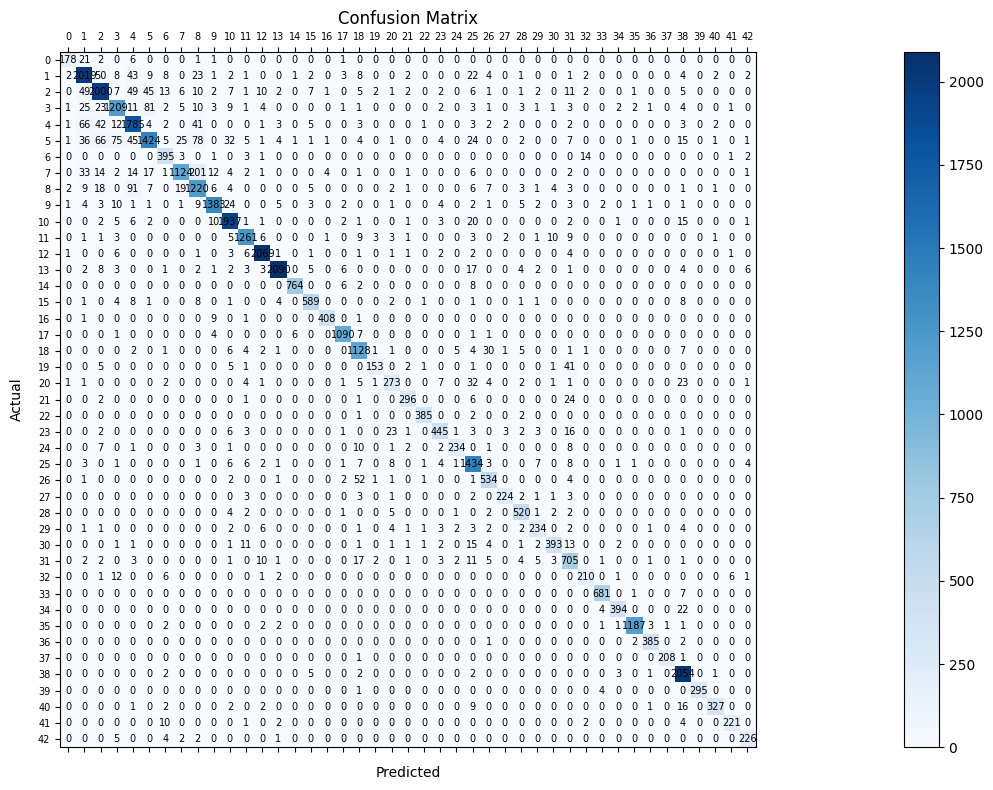

In [17]:
accuracy = evaluator_accuracy.evaluate(final_predictions)
f1 = evaluator_f1.evaluate(final_predictions)

print(f"Final results:")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

show_confusion_matrix(final_predictions)

Random Forest

In [18]:
rf = RandomForestClassifier(featuresCol="features", labelCol="ClassId")
pipeline = Pipeline(stages=[rf])

paramGrid_rf = ParamGridBuilder() \
  .addGrid(rf.numTrees, [20]) \
  .addGrid(rf.maxDepth, [20]) \
  .addGrid(rf.maxBins, [12]) \
  .build()

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_accuracy, numFolds=5, seed=1234)

model = cv.fit(train_df)

bestModel = model.bestModel
bestModel.write().overwrite().save("best-model-rf")

In [19]:
bestModel = PipelineModel.load("best-model-rf")

predictions = bestModel.transform(test_df)
accuracy = evaluator_accuracy.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print(f"Best accuracy: {accuracy}")
print(f"Best f1: {f1}")


print(f"Best param: numTrees={bestModel.stages[-1].getNumTrees} maxDepth={bestModel.stages[-1].getMaxDepth()} maxBins={bestModel.stages[-1].getMaxBins()}")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



Best accuracy: 0.9536406831899319
Best f1: 0.9534518319835216
Best param: numTrees=20 maxDepth=20 maxBins=12


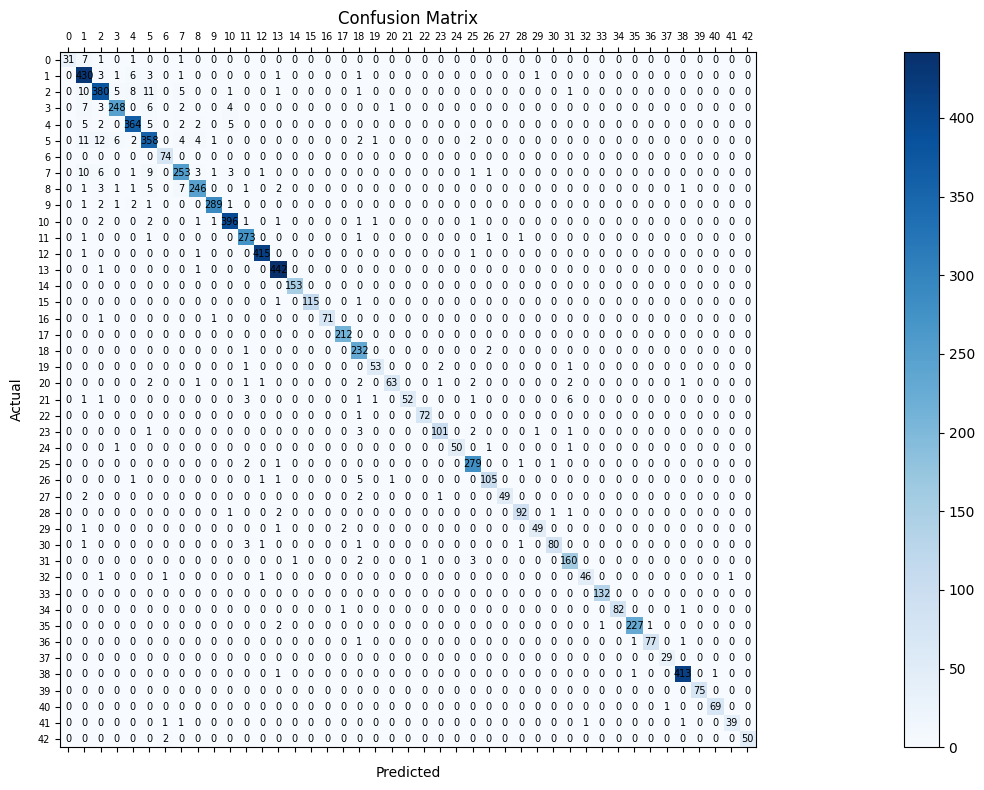

In [20]:
show_confusion_matrix(predictions)

In [21]:
test_metadata_df = spark.read.csv(os.path.join(dataset_path, 'Test.csv'), schema=schema, header=True)
test_metadata_df = test_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), test_metadata_df["Path"]))

processed_test_df = test_metadata_df.withColumn(
    "features",
    udf(lambda path, x1, y1, x2, y2: process_image(path, x1, y1, x2, y2), ArrayType(FloatType()))(
        test_metadata_df["Path"], test_metadata_df["`Roi.X1`"], test_metadata_df["`Roi.Y1`"],
        test_metadata_df["`Roi.X2`"], test_metadata_df["`Roi.Y2`"]
    )
)

processed_df = processed_df.withColumn("features", image_to_vector_udf("features"))

processed_df.show()

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



+-----+------+------+------+------+------+-------+--------------------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|
+-----+------+------+------+------+------+-------+--------------------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|[0.2,0.1960784313...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|[0.19607843137254...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...

In [22]:
final_predictions = bestModel.transform(processed_df)

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              



Final results:
Accuracy: 0.9897472519064501
F1: 0.9897411048889279


Current mem limits: 12884901888 of max 12884901888



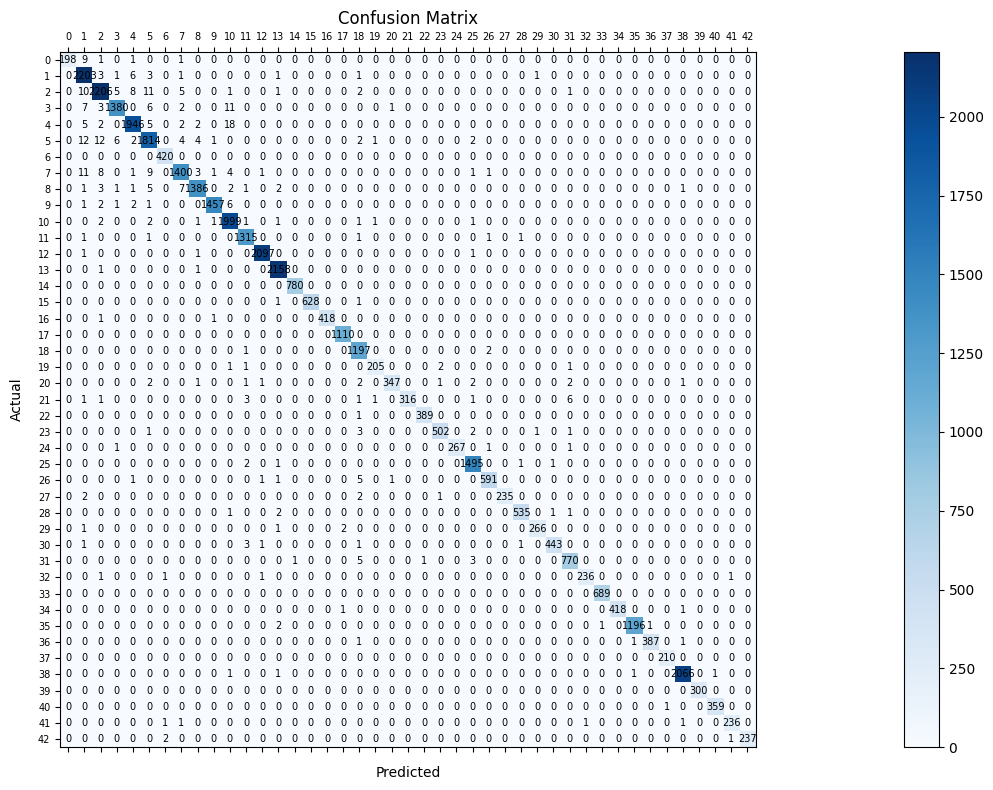

In [23]:
accuracy = evaluator_accuracy.evaluate(final_predictions)
f1 = evaluator_f1.evaluate(final_predictions)

print(f"Final results:")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

show_confusion_matrix(final_predictions)